In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm import tqdm
import warnings
from scipy.spatial.distance import cdist
from joblib import Parallel, delayed


# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
class PositionalEncoding(nn.Module):
    """
    Adds positional information to node embeddings.
    """
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor of shape (batch_size, seq_length, d_model)
        Returns:
            Tensor of shape (batch_size, seq_length, d_model)
        """
        x = x + self.pe[:, :x.size(1)]
        return x

class TransformerModel(nn.Module):
    """
    Transformer model that predicts pheromone matrix given node coordinates.
    """
    def __init__(self, num_nodes, d_model=128, nhead=8, num_layers=8, dropout=0.1, learnable_pos=False):
        super(TransformerModel, self).__init__()
        self.d_model = d_model
        self.input_projection = nn.Linear(2, d_model)

        # Use learnable positional encoding if specified
        if learnable_pos:
            self.pos_encoder = nn.Parameter(torch.zeros(1, num_nodes, d_model))
            nn.init.uniform_(self.pos_encoder, -0.02, 0.02)
        else:
            self.pos_encoder = PositionalEncoding(d_model)

        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward=512, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.output_projection = nn.Linear(d_model, d_model)
        self.final_activation = nn.ReLU()

    def forward(self, x):
        """
        Args:
            x: Tensor of shape (batch_size, num_nodes, 2)  # Node coordinates
        Returns:
            pheromone_matrix: Tensor of shape (batch_size, num_nodes, num_nodes)
        """
        x = self.input_projection(x)
        x = x * np.sqrt(self.d_model)

        # Apply positional encoding
        if isinstance(self.pos_encoder, nn.Parameter):
            x = x + self.pos_encoder[:, :x.size(1)]
        else:
            x = self.pos_encoder(x)

        x = self.transformer_encoder(x)
        x = self.output_projection(x)
        pheromone_matrix = torch.matmul(x, x.transpose(1, 2))
        pheromone_matrix = self.final_activation(pheromone_matrix)
        return pheromone_matrix



In [3]:
class StandardAntColonyOptimizer:
    """
    Implements the standard Ant Colony Optimization algorithm for TSP.
    Used for generating synthetic data and serving as a baseline.
    """
    def __init__(self, num_nodes, distance_matrix, num_ants=10, alpha=1.0, beta=2.0, evaporation_rate=0.5, Q=100):
        self.num_nodes = num_nodes
        self.distance_matrix = distance_matrix
        self.num_ants = num_ants
        self.alpha = alpha
        self.beta = beta
        self.evaporation_rate = evaporation_rate
        self.Q = Q
        self.pheromone = np.ones((num_nodes, num_nodes))
        self.best_distance = float('inf')
        self.best_solution = None

    def optimize(self, iterations=50):
        """
        Runs the ACO algorithm for a specified number of iterations.
        """
        for iteration in range(iterations):
            all_solutions = []
            all_distances = []
            for _ in range(self.num_ants):
                solution = self.construct_solution()
                distance = self.calculate_total_distance(solution)
                all_solutions.append(solution)
                all_distances.append(distance)
                if distance < self.best_distance:
                    self.best_distance = distance
                    self.best_solution = solution
            self.update_pheromone(all_solutions, all_distances)
        return self.best_solution, self.best_distance

    def construct_solution(self):
        """
        Constructs a solution (tour) by probabilistically selecting the next node based on pheromone and heuristic.
        """
        solution = []
        visited = set()
        current_node = np.random.randint(0, self.num_nodes)
        solution.append(current_node)
        visited.add(current_node)

        for _ in range(self.num_nodes - 1):
            probabilities = self.calculate_transition_probabilities(current_node, visited)
            next_node = np.random.choice(range(self.num_nodes), p=probabilities)
            solution.append(next_node)
            visited.add(next_node)
            current_node = next_node
        return solution

    def calculate_transition_probabilities(self, current_node, visited):
        """
        Calculates the probability of moving to each node not yet visited.
        """
        pheromone = self.pheromone[current_node] ** self.alpha
        heuristic = (1.0 / (self.distance_matrix[current_node] + 1e-10)) ** self.beta
        pheromone[list(visited)] = 0
        heuristic[list(visited)] = 0

        numerator = pheromone * heuristic
        denominator = np.sum(numerator)
        if denominator == 0:
            probabilities = np.ones(self.num_nodes) / self.num_nodes
        else:
            probabilities = numerator / denominator
        return probabilities

    def update_pheromone(self, solutions, distances):
        """
        Updates pheromone levels based on the solutions found by ants.
        """
        self.pheromone *= (1 - self.evaporation_rate)

        for solution, distance in zip(solutions, distances):
            pheromone_increment = self.Q / distance
            for i in range(len(solution) - 1):
                from_node = solution[i]
                to_node = solution[i + 1]
                self.pheromone[from_node][to_node] += pheromone_increment
            from_node = solution[-1]
            to_node = solution[0]
            self.pheromone[from_node][to_node] += pheromone_increment

    def calculate_total_distance(self, solution):
        """
        Calculates the total distance of the tour.
        """
        distance = 0.0
        for i in range(len(solution) - 1):
            distance += self.distance_matrix[solution[i]][solution[i + 1]]
        distance += self.distance_matrix[solution[-1]][solution[0]]
        return distance

class TransformerAntColonyOptimizer:
    """
    Enhanced ACO algorithm where the initial pheromone matrix is predicted by the Transformer model.
    """
    def __init__(self, num_nodes, distance_matrix, initial_pheromone=None, num_ants=10, alpha=1.0, beta=2.0, evaporation_rate=0.5, Q=100):
        self.num_nodes = num_nodes
        self.distance_matrix = distance_matrix
        self.num_ants = num_ants
        self.alpha = alpha
        self.beta = beta
        self.evaporation_rate = evaporation_rate
        self.Q = Q
        if initial_pheromone is not None:
            self.pheromone = initial_pheromone  # Use the provided initial pheromone matrix
        else:
            self.pheromone = np.ones((num_nodes, num_nodes))  # Initialize pheromone levels uniformly
        self.best_distance = float('inf')
        self.best_solution = None

    def optimize(self, iterations=50):
        """
        Runs the TransformerACO algorithm for a specified number of iterations.
        """
        for iteration in range(iterations):
            all_solutions = []
            all_distances = []
            for _ in range(self.num_ants):
                solution = self.construct_solution()
                distance = self.calculate_total_distance(solution)
                all_solutions.append(solution)
                all_distances.append(distance)
                if distance < self.best_distance:
                    self.best_distance = distance
                    self.best_solution = solution
            self.update_pheromone(all_solutions, all_distances)
        return self.best_solution, self.best_distance

    def construct_solution(self):
        """
        Constructs a solution (tour) by probabilistically selecting the next node based on pheromone and heuristic.
        """
        solution = []
        visited = set()
        current_node = np.random.randint(0, self.num_nodes)
        solution.append(current_node)
        visited.add(current_node)

        for _ in range(self.num_nodes - 1):
            probabilities = self.calculate_transition_probabilities(current_node, visited)
            next_node = np.random.choice(range(self.num_nodes), p=probabilities)
            solution.append(next_node)
            visited.add(next_node)
            current_node = next_node
        return solution

    def calculate_transition_probabilities(self, current_node, visited):
        """
        Calculates the probability of moving to each node not yet visited.
        """
        pheromone = self.pheromone[current_node] ** self.alpha
        heuristic = (1.0 / (self.distance_matrix[current_node] + 1e-10)) ** self.beta
        pheromone[list(visited)] = 0
        heuristic[list(visited)] = 0

        numerator = pheromone * heuristic
        denominator = np.sum(numerator)
        if denominator == 0:
            probabilities = np.ones(self.num_nodes) / self.num_nodes
        else:
            probabilities = numerator / denominator
        return probabilities

    def update_pheromone(self, solutions, distances):
        """
        Updates pheromone levels based on the solutions found by ants.
        """
        self.pheromone *= (1 - self.evaporation_rate)

        for solution, distance in zip(solutions, distances):
            pheromone_increment = self.Q / distance
            for i in range(len(solution) - 1):
                from_node = solution[i]
                to_node = solution[i + 1]
                self.pheromone[from_node][to_node] += pheromone_increment
            from_node = solution[-1]
            to_node = solution[0]
            self.pheromone[from_node][to_node] += pheromone_increment

    def calculate_total_distance(self, solution):
        """
        Calculates the total distance of the tour.
        """
        distance = 0.0
        for i in range(len(solution) - 1):
            distance += self.distance_matrix[solution[i]][solution[i + 1]]
        distance += self.distance_matrix[solution[-1]][solution[0]]
        return distance

In [4]:
import numpy as np
from tqdm import tqdm
from scipy.spatial.distance import cdist
from joblib import Parallel, delayed

def generate_tsp_solutions(num_nodes, num_samples=100, num_ants=50, iterations=100, n_jobs=-1):
    """
    Generates TSP solutions and pheromone matrices for randomly generated node coordinates.
    Utilizes parallel processing to speed up computation.

    Parameters:
    - num_nodes: Number of nodes in the TSP problem.
    - num_samples: Number of random TSP instances to generate.
    - num_ants: Number of ants in the ACO algorithm.
    - iterations: Number of iterations for the ACO algorithm.
    - n_jobs: Number of parallel jobs. -1 means using all processors.

    Returns:
    - coordinates_list: Array of node coordinates for each sample.
    - pheromone_matrices: Array of pheromone matrices for each sample.
    """
    def process_sample(_):
        # Generate random coordinates for nodes
        coordinates = np.random.rand(num_nodes, 2)

        # Compute Euclidean distance matrix using scipy for efficiency
        distance_matrix = cdist(coordinates, coordinates, metric='euclidean')

        try:
            # Initialize and run the ACO optimizer
            standard_aco = StandardAntColonyOptimizer(
                num_nodes=num_nodes,
                distance_matrix=distance_matrix,
                num_ants=num_ants,
                alpha=1.0,
                beta=2.0,
                evaporation_rate=0.3,
                Q=100
            )
            standard_aco.optimize(iterations=iterations)

            # Get and normalize the pheromone matrix
            pheromone_matrix = standard_aco.pheromone.copy()
            pheromone_matrix -= pheromone_matrix.min()
            max_val = pheromone_matrix.max()
            pheromone_matrix /= max_val if max_val > 0 else 1

            return coordinates, pheromone_matrix
        except Exception as e:
            print(f"Error processing sample: {e}")
            return None, None

    # Use parallel processing to handle multiple samples concurrently
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_sample)(i) for i in tqdm(range(num_samples), desc="Generating TSP Solutions")
    )

    # Filter out any None results from failed samples
    results = [res for res in results if res[0] is not None]

    # Unpack the results
    coordinates_list, pheromone_matrices = zip(*results)

    return np.array(coordinates_list), np.array(pheromone_matrices)

# Example usage:
# coordinates, pheromones = generate_tsp_solutions(num_nodes=50, num_samples=100, n_jobs=-1)


In [10]:
def run_experiment(node_sizes, num_trials=50, iterations=100, num_ants=50, alpha=1.0, beta=2.0, evaporation_rate=0.3, Q=100):
    """
    Runs experiments comparing StandardACO and TransformerACO across multiple node sizes.
    Prints comparisons for each trial and plots the results.
    """
    results = {}

    for num_nodes in node_sizes:
        print(f"\n=== Node Size: {num_nodes} ===")

        print("Generating synthetic data for training...")
        coordinates_list, pheromone_matrices = generate_tsp_solutions(
            num_nodes=num_nodes,
            num_samples=500
        )

        split_index = int(0.8 * len(coordinates_list))
        train_coords = coordinates_list[:split_index]
        val_coords = coordinates_list[split_index:]
        train_pheromones = pheromone_matrices[:split_index]
        val_pheromones = pheromone_matrices[split_index:]

        train_coords_tensor = torch.tensor(train_coords, dtype=torch.float).to(device)
        train_pheromone_tensors = torch.tensor(train_pheromones, dtype=torch.float).to(device)
        val_coords_tensor = torch.tensor(val_coords, dtype=torch.float).to(device)
        val_pheromone_tensors = torch.tensor(val_pheromones, dtype=torch.float).to(device)

        model = TransformerModel(num_nodes=num_nodes, d_model=128, nhead=8, num_layers=8, dropout=0.1, learnable_pos=True).to(device)
        criterion = nn.MSELoss()
        optimizer_model = optim.Adam(model.parameters(), lr=0.001)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_model, 'min', patience=5, factor=0.5)

        print("Training Transformer Model...")
        epochs = 1000
        batch_size = 32
        num_samples = train_coords_tensor.size(0)
        best_val_loss = float('inf')
        patience = 10
        patience_counter = 0

        for epoch in range(epochs):
            # Training
            model.train()
            permutation = torch.randperm(num_samples)
            train_loss = 0.0
            for i in range(0, num_samples, batch_size):
                indices = permutation[i:i+batch_size]
                input_batch = train_coords_tensor[indices]
                target_batch = train_pheromone_tensors[indices]

                optimizer_model.zero_grad()
                output = model(input_batch)
                loss = criterion(output, target_batch)
                loss.backward()
                optimizer_model.step()

                train_loss += loss.item()

            avg_train_loss = train_loss / (num_samples / batch_size)

            model.eval()
            with torch.no_grad():
                val_output = model(val_coords_tensor)
                val_loss = criterion(val_output, val_pheromone_tensors).item()

            scheduler.step(val_loss)

            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                # Save the best model
                torch.save(model.state_dict(), f'best_model_{num_nodes}.pth')
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("Early stopping triggered.")
                    break

        model.load_state_dict(torch.load(f'best_model_{num_nodes}.pth'))

        results[num_nodes] = {'StandardACO': [], 'TransformerACO': []}

        print(f"Running {num_trials} trials for node size {num_nodes}...")
        for trial in tqdm(range(num_trials), desc=f"Trials for node size {num_nodes}"):
            trial_number = trial + 1
            coordinates = np.random.rand(num_nodes, 2)
            distance_matrix = np.sqrt(
                (coordinates[:, np.newaxis, 0] - coordinates[np.newaxis, :, 0]) ** 2 +
                (coordinates[:, np.newaxis, 1] - coordinates[np.newaxis, :, 1]) ** 2
            )

            coordinates_input = torch.tensor(coordinates[np.newaxis, :, :], dtype=torch.float).to(device)
            with torch.no_grad():
                model.eval()
                predicted_pheromone = model(coordinates_input)
            predicted_pheromone_np = predicted_pheromone.cpu().numpy()[0]

            predicted_pheromone_np -= predicted_pheromone_np.min()
            predicted_pheromone_np /= predicted_pheromone_np.max() if predicted_pheromone_np.max() > 0 else 1
            predicted_pheromone_np += 1e-6

            standard_aco = StandardAntColonyOptimizer(
                num_nodes=num_nodes,
                distance_matrix=distance_matrix,
                num_ants=num_ants,
                alpha=alpha,
                beta=beta,
                evaporation_rate=evaporation_rate,
                Q=Q
            )
            transformer_aco = TransformerAntColonyOptimizer(
                num_nodes=num_nodes,
                distance_matrix=distance_matrix,
                initial_pheromone=predicted_pheromone_np,
                num_ants=num_ants,
                alpha=alpha,
                beta=beta,
                evaporation_rate=evaporation_rate,
                Q=Q
            )

            _, best_distance_standard = standard_aco.optimize(iterations=iterations)
            _, best_distance_transformer = transformer_aco.optimize(iterations=iterations)

            results[num_nodes]['StandardACO'].append(best_distance_standard)
            results[num_nodes]['TransformerACO'].append(best_distance_transformer)

            print(f"Trial {trial_number}: StandardACO Best Distance = {best_distance_standard:.4f}, TransformerACO Best Distance = {best_distance_transformer:.4f}")

        # Plotting results for this node size
        plt.figure(figsize=(10, 6))
        plt.plot(results[num_nodes]['StandardACO'], label='StandardACO', marker='o')
        plt.plot(results[num_nodes]['TransformerACO'], label='TransformerACO', marker='s')
        plt.title(f"Best Distances for Node Size: {num_nodes}")
        plt.xlabel("Trial")
        plt.ylabel("Best Distance")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Boxplot for distribution of best distances
        plt.figure(figsize=(10, 6))
        plt.boxplot([results[num_nodes]['StandardACO'], results[num_nodes]['TransformerACO']], labels=['StandardACO', 'TransformerACO'])
        plt.title(f"Distribution of Best Distances for Node Size: {num_nodes} (Averaged Over Runs)")
        plt.ylabel("Best Distance")
        plt.grid(True)
        plt.show()

        del model

    return results


In [11]:
def perform_statistical_tests(results):
    """
    Performs Wilcoxon signed-rank tests for each node size.
    Returns a dictionary of p-values.
    """
    node_sizes = sorted(results.keys())
    p_values = {}

    for num_nodes in node_sizes:
        standard = results[num_nodes]['StandardACO']
        transformer = results[num_nodes]['TransformerACO']
        stat, p = stats.wilcoxon(standard, transformer)
        p_values[num_nodes] = p
        print(f"Node Size {num_nodes}: p-value = {p:.4e}")

    return p_values

In [12]:
def plot_results(results, p_values):
    """
    Plots average best distances for StandardACO and TransformerACO across node sizes.
    Annotates significance based on p-values.
    """
    node_sizes = sorted(results.keys())
    standard_means = [np.mean(results[size]['StandardACO']) for size in node_sizes]
    transformer_means = [np.mean(results[size]['TransformerACO']) for size in node_sizes]
    standard_stds = [np.std(results[size]['StandardACO']) for size in node_sizes]
    transformer_stds = [np.std(results[size]['TransformerACO']) for size in node_sizes]

    x = np.arange(len(node_sizes))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width/2, standard_means, width, yerr=standard_stds, label='Standard ACO', capsize=5, color='skyblue')
    rects2 = ax.bar(x + width/2, transformer_means, width, yerr=transformer_stds, label='TransformerACO (Transformer)', capsize=5, color='salmon')

    ax.set_ylabel('Average Best Distance')
    ax.set_xlabel('Number of Nodes')
    ax.set_title('Comparison of StandardACO vs. TransformerACO Across Different Node Sizes')
    ax.set_xticks(x)
    ax.set_xticklabels(node_sizes)
    ax.legend()

    for i, size in enumerate(node_sizes):
        p = p_values[size]
        if p < 0.001:
            significance = '***'
        elif p < 0.01:
            significance = '**'
        elif p < 0.05:
            significance = '*'
        else:
            significance = 'ns'
        ax.text(x[i], max(standard_means[i], transformer_means[i]) + max(standard_stds[i], transformer_stds[i]) + 0.05, significance, ha='center', va='bottom', color='black', fontsize=12)

    plt.tight_layout()
    plt.show()


=== Node Size: 30 ===
Generating synthetic data for training...



Generating TSP Solutions: 100%|██████████| 500/500 [09:32<00:00,  1.15s/it]


Training Transformer Model...
Epoch 1/1000, Train Loss: 198.9393, Val Loss: 8.3278
Epoch 2/1000, Train Loss: 3.8297, Val Loss: 1.1140
Epoch 3/1000, Train Loss: 0.8739, Val Loss: 0.2160
Epoch 4/1000, Train Loss: 0.3705, Val Loss: 0.0513
Epoch 5/1000, Train Loss: 0.2503, Val Loss: 0.0240
Epoch 6/1000, Train Loss: 0.2167, Val Loss: 0.0189
Epoch 7/1000, Train Loss: 0.1988, Val Loss: 0.0183
Epoch 8/1000, Train Loss: 0.1867, Val Loss: 0.0183
Epoch 9/1000, Train Loss: 0.1771, Val Loss: 0.0183
Epoch 10/1000, Train Loss: 0.1681, Val Loss: 0.0184
Epoch 11/1000, Train Loss: 0.1587, Val Loss: 0.0183
Epoch 12/1000, Train Loss: 0.1472, Val Loss: 0.0187
Epoch 13/1000, Train Loss: 0.1405, Val Loss: 0.0182
Epoch 14/1000, Train Loss: 0.1330, Val Loss: 0.0185
Epoch 15/1000, Train Loss: 0.1294, Val Loss: 0.0185
Epoch 16/1000, Train Loss: 0.1247, Val Loss: 0.0184
Epoch 17/1000, Train Loss: 0.1203, Val Loss: 0.0185
Epoch 18/1000, Train Loss: 0.1143, Val Loss: 0.0185
Epoch 19/1000, Train Loss: 0.1106, Val Lo

<ipython-input-10-801569d92a95>:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_model_{num_nodes}.pth'))


Epoch 23/1000, Train Loss: 0.1030, Val Loss: 0.0185
Early stopping triggered.
Running 100 trials for node size 30...



Trials for node size 30:   1%|          | 1/100 [00:03<05:08,  3.12s/it]

Trial 1: StandardACO Best Distance = 4.7747, TransformerACO Best Distance = 4.6789



Trials for node size 30:   2%|▏         | 2/100 [00:06<05:11,  3.18s/it]

Trial 2: StandardACO Best Distance = 4.4897, TransformerACO Best Distance = 4.4505



Trials for node size 30:   3%|▎         | 3/100 [00:09<05:14,  3.25s/it]

Trial 3: StandardACO Best Distance = 4.9708, TransformerACO Best Distance = 4.9273



Trials for node size 30:   4%|▍         | 4/100 [00:12<05:09,  3.22s/it]

Trial 4: StandardACO Best Distance = 4.2786, TransformerACO Best Distance = 4.2761



Trials for node size 30:   5%|▌         | 5/100 [00:15<05:02,  3.19s/it]

Trial 5: StandardACO Best Distance = 4.5534, TransformerACO Best Distance = 4.5392



Trials for node size 30:   6%|▌         | 6/100 [00:19<05:00,  3.20s/it]

Trial 6: StandardACO Best Distance = 4.0325, TransformerACO Best Distance = 4.1072



Trials for node size 30:   7%|▋         | 7/100 [00:22<04:56,  3.19s/it]

Trial 7: StandardACO Best Distance = 4.9780, TransformerACO Best Distance = 5.1817



Trials for node size 30:   8%|▊         | 8/100 [00:25<04:51,  3.17s/it]

Trial 8: StandardACO Best Distance = 4.6697, TransformerACO Best Distance = 4.7456



Trials for node size 30:   9%|▉         | 9/100 [00:28<04:50,  3.19s/it]

Trial 9: StandardACO Best Distance = 4.7312, TransformerACO Best Distance = 4.6850



Trials for node size 30:  10%|█         | 10/100 [00:31<04:44,  3.16s/it]

Trial 10: StandardACO Best Distance = 4.6558, TransformerACO Best Distance = 4.7167



Trials for node size 30:  11%|█         | 11/100 [00:34<04:39,  3.14s/it]

Trial 11: StandardACO Best Distance = 4.4644, TransformerACO Best Distance = 4.3985



Trials for node size 30:  12%|█▏        | 12/100 [00:38<04:40,  3.19s/it]

Trial 12: StandardACO Best Distance = 4.8491, TransformerACO Best Distance = 4.8438



Trials for node size 30:  13%|█▎        | 13/100 [00:41<04:35,  3.17s/it]

Trial 13: StandardACO Best Distance = 4.9458, TransformerACO Best Distance = 5.0485



Trials for node size 30:  14%|█▍        | 14/100 [00:44<04:30,  3.15s/it]

Trial 14: StandardACO Best Distance = 4.4540, TransformerACO Best Distance = 4.4540



Trials for node size 30:  15%|█▌        | 15/100 [00:47<04:28,  3.16s/it]

Trial 15: StandardACO Best Distance = 4.8655, TransformerACO Best Distance = 4.7877



Trials for node size 30:  16%|█▌        | 16/100 [00:50<04:24,  3.15s/it]

Trial 16: StandardACO Best Distance = 4.5284, TransformerACO Best Distance = 4.5428



Trials for node size 30:  17%|█▋        | 17/100 [00:53<04:22,  3.16s/it]

Trial 17: StandardACO Best Distance = 4.8638, TransformerACO Best Distance = 4.8612



Trials for node size 30:  18%|█▊        | 18/100 [00:57<04:18,  3.15s/it]

Trial 18: StandardACO Best Distance = 4.1884, TransformerACO Best Distance = 3.9672



Trials for node size 30:  19%|█▉        | 19/100 [01:00<04:14,  3.14s/it]

Trial 19: StandardACO Best Distance = 4.7138, TransformerACO Best Distance = 4.7306



Trials for node size 30:  20%|██        | 20/100 [01:03<04:10,  3.14s/it]

Trial 20: StandardACO Best Distance = 4.9882, TransformerACO Best Distance = 4.9655



Trials for node size 30:  21%|██        | 21/100 [01:06<04:10,  3.17s/it]

Trial 21: StandardACO Best Distance = 4.7471, TransformerACO Best Distance = 4.7099



Trials for node size 30:  22%|██▏       | 22/100 [01:09<04:08,  3.19s/it]

Trial 22: StandardACO Best Distance = 4.0347, TransformerACO Best Distance = 3.9797



Trials for node size 30:  23%|██▎       | 23/100 [01:12<04:03,  3.17s/it]

Trial 23: StandardACO Best Distance = 5.0488, TransformerACO Best Distance = 5.2249



Trials for node size 30:  24%|██▍       | 24/100 [01:16<04:00,  3.16s/it]

Trial 24: StandardACO Best Distance = 4.8100, TransformerACO Best Distance = 4.7737



Trials for node size 30:  25%|██▌       | 25/100 [01:19<03:57,  3.16s/it]

Trial 25: StandardACO Best Distance = 4.6183, TransformerACO Best Distance = 4.7760



Trials for node size 30:  26%|██▌       | 26/100 [01:22<03:53,  3.16s/it]

Trial 26: StandardACO Best Distance = 4.4037, TransformerACO Best Distance = 4.4554



Trials for node size 30:  27%|██▋       | 27/100 [01:25<03:49,  3.14s/it]

Trial 27: StandardACO Best Distance = 4.6021, TransformerACO Best Distance = 4.4555



Trials for node size 30:  28%|██▊       | 28/100 [01:28<03:48,  3.17s/it]

Trial 28: StandardACO Best Distance = 4.8732, TransformerACO Best Distance = 4.7248



Trials for node size 30:  29%|██▉       | 29/100 [01:31<03:44,  3.17s/it]

Trial 29: StandardACO Best Distance = 4.9415, TransformerACO Best Distance = 4.8733



Trials for node size 30:  30%|███       | 30/100 [01:34<03:40,  3.14s/it]

Trial 30: StandardACO Best Distance = 4.8535, TransformerACO Best Distance = 4.9263



Trials for node size 30:  31%|███       | 31/100 [01:38<03:37,  3.15s/it]

Trial 31: StandardACO Best Distance = 4.6495, TransformerACO Best Distance = 4.6792



Trials for node size 30:  32%|███▏      | 32/100 [01:41<03:35,  3.16s/it]

Trial 32: StandardACO Best Distance = 5.1193, TransformerACO Best Distance = 4.8207



Trials for node size 30:  33%|███▎      | 33/100 [01:44<03:38,  3.27s/it]

Trial 33: StandardACO Best Distance = 4.8065, TransformerACO Best Distance = 4.8011



Trials for node size 30:  34%|███▍      | 34/100 [01:47<03:32,  3.21s/it]

Trial 34: StandardACO Best Distance = 4.5408, TransformerACO Best Distance = 4.7530



Trials for node size 30:  35%|███▌      | 35/100 [01:51<03:30,  3.23s/it]

Trial 35: StandardACO Best Distance = 5.0658, TransformerACO Best Distance = 4.9831



Trials for node size 30:  36%|███▌      | 36/100 [01:54<03:26,  3.23s/it]

Trial 36: StandardACO Best Distance = 5.0894, TransformerACO Best Distance = 5.3101



Trials for node size 30:  37%|███▋      | 37/100 [01:57<03:21,  3.20s/it]

Trial 37: StandardACO Best Distance = 4.1784, TransformerACO Best Distance = 4.1804



Trials for node size 30:  38%|███▊      | 38/100 [02:00<03:16,  3.17s/it]

Trial 38: StandardACO Best Distance = 4.8951, TransformerACO Best Distance = 4.9139



Trials for node size 30:  39%|███▉      | 39/100 [02:03<03:11,  3.15s/it]

Trial 39: StandardACO Best Distance = 4.7883, TransformerACO Best Distance = 4.8526



Trials for node size 30:  40%|████      | 40/100 [02:07<03:11,  3.19s/it]

Trial 40: StandardACO Best Distance = 4.7900, TransformerACO Best Distance = 4.6727



Trials for node size 30:  41%|████      | 41/100 [02:10<03:06,  3.16s/it]

Trial 41: StandardACO Best Distance = 4.8155, TransformerACO Best Distance = 4.8155



Trials for node size 30:  42%|████▏     | 42/100 [02:13<03:02,  3.15s/it]

Trial 42: StandardACO Best Distance = 4.2239, TransformerACO Best Distance = 4.1758



Trials for node size 30:  43%|████▎     | 43/100 [02:16<02:59,  3.15s/it]

Trial 43: StandardACO Best Distance = 4.7663, TransformerACO Best Distance = 4.8193



Trials for node size 30:  44%|████▍     | 44/100 [02:19<02:56,  3.16s/it]

Trial 44: StandardACO Best Distance = 5.1552, TransformerACO Best Distance = 5.1100



Trials for node size 30:  45%|████▌     | 45/100 [02:22<02:53,  3.16s/it]

Trial 45: StandardACO Best Distance = 4.1873, TransformerACO Best Distance = 4.1503



Trials for node size 30:  46%|████▌     | 46/100 [02:25<02:49,  3.14s/it]

Trial 46: StandardACO Best Distance = 4.8829, TransformerACO Best Distance = 4.6443



Trials for node size 30:  47%|████▋     | 47/100 [02:28<02:46,  3.14s/it]

Trial 47: StandardACO Best Distance = 4.3087, TransformerACO Best Distance = 4.5523



Trials for node size 30:  48%|████▊     | 48/100 [02:32<02:49,  3.25s/it]

Trial 48: StandardACO Best Distance = 4.2414, TransformerACO Best Distance = 4.3101



Trials for node size 30:  49%|████▉     | 49/100 [02:35<02:43,  3.21s/it]

Trial 49: StandardACO Best Distance = 5.0265, TransformerACO Best Distance = 4.9971



Trials for node size 30:  50%|█████     | 50/100 [02:38<02:39,  3.19s/it]

Trial 50: StandardACO Best Distance = 4.3016, TransformerACO Best Distance = 4.4332



Trials for node size 30:  51%|█████     | 51/100 [02:41<02:35,  3.17s/it]

Trial 51: StandardACO Best Distance = 4.2064, TransformerACO Best Distance = 4.1980



Trials for node size 30:  52%|█████▏    | 52/100 [02:45<02:31,  3.16s/it]

Trial 52: StandardACO Best Distance = 5.0542, TransformerACO Best Distance = 5.0489



Trials for node size 30:  53%|█████▎    | 53/100 [02:48<02:28,  3.16s/it]

Trial 53: StandardACO Best Distance = 4.4563, TransformerACO Best Distance = 4.4914



Trials for node size 30:  54%|█████▍    | 54/100 [02:51<02:25,  3.17s/it]

Trial 54: StandardACO Best Distance = 4.6779, TransformerACO Best Distance = 4.6043



Trials for node size 30:  55%|█████▌    | 55/100 [02:54<02:23,  3.18s/it]

Trial 55: StandardACO Best Distance = 4.5916, TransformerACO Best Distance = 4.5877



Trials for node size 30:  56%|█████▌    | 56/100 [02:58<02:25,  3.31s/it]

Trial 56: StandardACO Best Distance = 4.5269, TransformerACO Best Distance = 4.5269



Trials for node size 30:  57%|█████▋    | 57/100 [03:01<02:20,  3.27s/it]

Trial 57: StandardACO Best Distance = 4.4752, TransformerACO Best Distance = 4.5759



Trials for node size 30:  58%|█████▊    | 58/100 [03:04<02:15,  3.23s/it]

Trial 58: StandardACO Best Distance = 4.8364, TransformerACO Best Distance = 4.8605



Trials for node size 30:  59%|█████▉    | 59/100 [03:07<02:13,  3.25s/it]

Trial 59: StandardACO Best Distance = 4.6274, TransformerACO Best Distance = 4.6802



Trials for node size 30:  60%|██████    | 60/100 [03:10<02:08,  3.20s/it]

Trial 60: StandardACO Best Distance = 4.2532, TransformerACO Best Distance = 4.2259



Trials for node size 30:  61%|██████    | 61/100 [03:14<02:06,  3.24s/it]

Trial 61: StandardACO Best Distance = 4.2999, TransformerACO Best Distance = 4.3534



Trials for node size 30:  62%|██████▏   | 62/100 [03:17<02:02,  3.22s/it]

Trial 62: StandardACO Best Distance = 4.6333, TransformerACO Best Distance = 4.5129



Trials for node size 30:  63%|██████▎   | 63/100 [03:20<02:00,  3.26s/it]

Trial 63: StandardACO Best Distance = 4.7077, TransformerACO Best Distance = 4.6092



Trials for node size 30:  64%|██████▍   | 64/100 [03:23<01:55,  3.21s/it]

Trial 64: StandardACO Best Distance = 4.5779, TransformerACO Best Distance = 4.6160



Trials for node size 30:  65%|██████▌   | 65/100 [03:27<01:52,  3.23s/it]

Trial 65: StandardACO Best Distance = 4.5855, TransformerACO Best Distance = 4.5554



Trials for node size 30:  66%|██████▌   | 66/100 [03:30<01:49,  3.21s/it]

Trial 66: StandardACO Best Distance = 4.3241, TransformerACO Best Distance = 4.3411



Trials for node size 30:  67%|██████▋   | 67/100 [03:33<01:50,  3.34s/it]

Trial 67: StandardACO Best Distance = 4.5563, TransformerACO Best Distance = 4.6449



Trials for node size 30:  68%|██████▊   | 68/100 [03:37<01:44,  3.28s/it]

Trial 68: StandardACO Best Distance = 4.7438, TransformerACO Best Distance = 4.6787



Trials for node size 30:  69%|██████▉   | 69/100 [03:40<01:40,  3.24s/it]

Trial 69: StandardACO Best Distance = 4.7746, TransformerACO Best Distance = 4.6253



Trials for node size 30:  70%|███████   | 70/100 [03:43<01:36,  3.23s/it]

Trial 70: StandardACO Best Distance = 4.7931, TransformerACO Best Distance = 4.8816



Trials for node size 30:  71%|███████   | 71/100 [03:46<01:32,  3.20s/it]

Trial 71: StandardACO Best Distance = 5.0836, TransformerACO Best Distance = 5.0539



Trials for node size 30:  72%|███████▏  | 72/100 [03:49<01:29,  3.19s/it]

Trial 72: StandardACO Best Distance = 4.4787, TransformerACO Best Distance = 4.5080



Trials for node size 30:  73%|███████▎  | 73/100 [03:52<01:26,  3.22s/it]

Trial 73: StandardACO Best Distance = 4.6045, TransformerACO Best Distance = 4.8381



Trials for node size 30:  74%|███████▍  | 74/100 [03:56<01:24,  3.26s/it]

Trial 74: StandardACO Best Distance = 4.5968, TransformerACO Best Distance = 4.7075



Trials for node size 30:  75%|███████▌  | 75/100 [03:59<01:20,  3.21s/it]

Trial 75: StandardACO Best Distance = 4.2119, TransformerACO Best Distance = 4.2081



Trials for node size 30:  76%|███████▌  | 76/100 [04:02<01:16,  3.18s/it]

Trial 76: StandardACO Best Distance = 4.2825, TransformerACO Best Distance = 4.3181



Trials for node size 30:  77%|███████▋  | 77/100 [04:05<01:12,  3.15s/it]

Trial 77: StandardACO Best Distance = 4.6948, TransformerACO Best Distance = 4.6335



Trials for node size 30:  78%|███████▊  | 78/100 [04:08<01:09,  3.16s/it]

Trial 78: StandardACO Best Distance = 4.9367, TransformerACO Best Distance = 4.9946



Trials for node size 30:  79%|███████▉  | 79/100 [04:11<01:05,  3.14s/it]

Trial 79: StandardACO Best Distance = 5.0557, TransformerACO Best Distance = 5.1184



Trials for node size 30:  80%|████████  | 80/100 [04:15<01:04,  3.21s/it]

Trial 80: StandardACO Best Distance = 4.2066, TransformerACO Best Distance = 4.2918



Trials for node size 30:  81%|████████  | 81/100 [04:18<01:00,  3.19s/it]

Trial 81: StandardACO Best Distance = 4.3137, TransformerACO Best Distance = 4.3137



Trials for node size 30:  82%|████████▏ | 82/100 [04:21<00:56,  3.15s/it]

Trial 82: StandardACO Best Distance = 5.1175, TransformerACO Best Distance = 5.0677



Trials for node size 30:  83%|████████▎ | 83/100 [04:24<00:53,  3.14s/it]

Trial 83: StandardACO Best Distance = 4.4821, TransformerACO Best Distance = 4.4638



Trials for node size 30:  84%|████████▍ | 84/100 [04:27<00:50,  3.17s/it]

Trial 84: StandardACO Best Distance = 5.0470, TransformerACO Best Distance = 5.0762



Trials for node size 30:  85%|████████▌ | 85/100 [04:30<00:47,  3.15s/it]

Trial 85: StandardACO Best Distance = 4.3272, TransformerACO Best Distance = 4.2666



Trials for node size 30:  86%|████████▌ | 86/100 [04:34<00:43,  3.13s/it]

Trial 86: StandardACO Best Distance = 4.9444, TransformerACO Best Distance = 4.8975



Trials for node size 30:  87%|████████▋ | 87/100 [04:37<00:40,  3.12s/it]

Trial 87: StandardACO Best Distance = 4.6005, TransformerACO Best Distance = 4.5919



Trials for node size 30:  88%|████████▊ | 88/100 [04:40<00:37,  3.10s/it]

Trial 88: StandardACO Best Distance = 4.8128, TransformerACO Best Distance = 4.6061



Trials for node size 30:  89%|████████▉ | 89/100 [04:43<00:34,  3.11s/it]

Trial 89: StandardACO Best Distance = 4.5853, TransformerACO Best Distance = 4.5666



Trials for node size 30:  90%|█████████ | 90/100 [04:46<00:30,  3.10s/it]

Trial 90: StandardACO Best Distance = 5.2352, TransformerACO Best Distance = 5.1820



Trials for node size 30:  91%|█████████ | 91/100 [04:49<00:27,  3.10s/it]

Trial 91: StandardACO Best Distance = 4.7312, TransformerACO Best Distance = 4.8674



Trials for node size 30:  92%|█████████▏| 92/100 [04:52<00:24,  3.10s/it]

Trial 92: StandardACO Best Distance = 4.9187, TransformerACO Best Distance = 5.0027



Trials for node size 30:  93%|█████████▎| 93/100 [04:55<00:21,  3.12s/it]

Trial 93: StandardACO Best Distance = 4.7085, TransformerACO Best Distance = 4.8446



Trials for node size 30:  94%|█████████▍| 94/100 [04:58<00:18,  3.12s/it]

Trial 94: StandardACO Best Distance = 4.4575, TransformerACO Best Distance = 4.3275



Trials for node size 30:  95%|█████████▌| 95/100 [05:01<00:15,  3.12s/it]

Trial 95: StandardACO Best Distance = 4.8228, TransformerACO Best Distance = 4.8102



Trials for node size 30:  96%|█████████▌| 96/100 [05:05<00:13,  3.30s/it]

Trial 96: StandardACO Best Distance = 5.1718, TransformerACO Best Distance = 4.9058



Trials for node size 30:  97%|█████████▋| 97/100 [05:08<00:09,  3.28s/it]

Trial 97: StandardACO Best Distance = 4.9825, TransformerACO Best Distance = 4.9084



Trials for node size 30:  98%|█████████▊| 98/100 [05:12<00:06,  3.29s/it]

Trial 98: StandardACO Best Distance = 4.5658, TransformerACO Best Distance = 4.7112



Trials for node size 30:  99%|█████████▉| 99/100 [05:15<00:03,  3.25s/it]

Trial 99: StandardACO Best Distance = 4.6033, TransformerACO Best Distance = 4.6042



Trials for node size 30: 100%|██████████| 100/100 [05:18<00:00,  3.19s/it]

Trial 100: StandardACO Best Distance = 4.5426, TransformerACO Best Distance = 4.9120


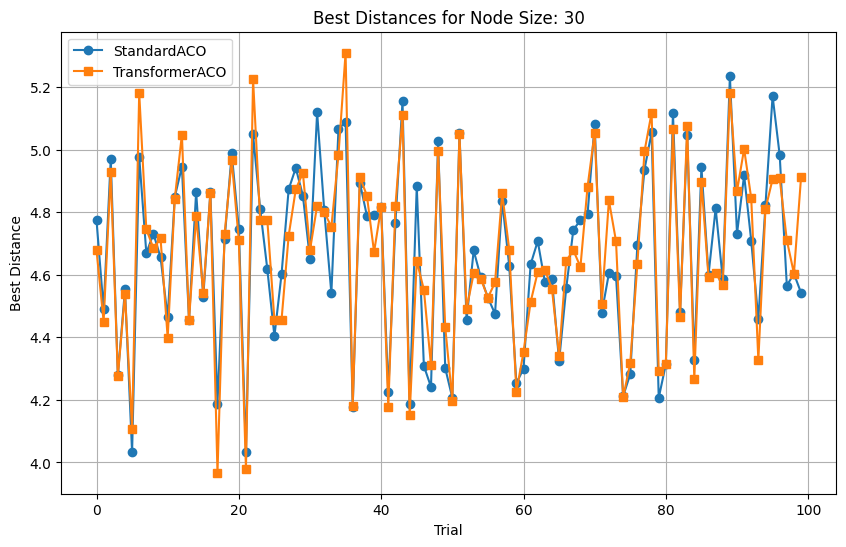

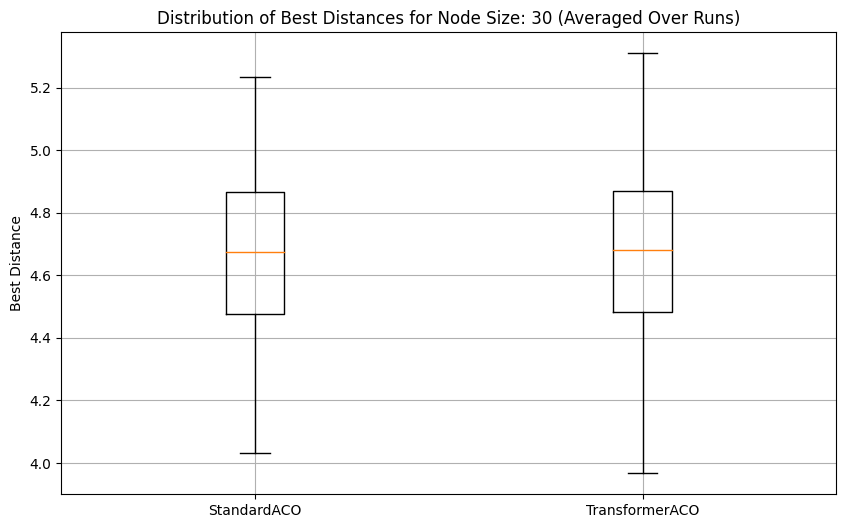


=== Node Size: 60 ===
Generating synthetic data for training...



Generating TSP Solutions: 100%|██████████| 500/500 [20:57<00:00,  2.51s/it]


Training Transformer Model...
Epoch 1/1000, Train Loss: 313.8556, Val Loss: 12.6846
Epoch 2/1000, Train Loss: 5.7486, Val Loss: 1.8360
Epoch 3/1000, Train Loss: 1.1662, Val Loss: 0.3813
Epoch 4/1000, Train Loss: 0.4195, Val Loss: 0.1022
Epoch 5/1000, Train Loss: 0.2474, Val Loss: 0.0359
Epoch 6/1000, Train Loss: 0.1890, Val Loss: 0.0187
Epoch 7/1000, Train Loss: 0.1649, Val Loss: 0.0129
Epoch 8/1000, Train Loss: 0.1490, Val Loss: 0.0109
Epoch 9/1000, Train Loss: 0.1374, Val Loss: 0.0103
Epoch 10/1000, Train Loss: 0.1275, Val Loss: 0.0101
Epoch 11/1000, Train Loss: 0.1184, Val Loss: 0.0100
Epoch 12/1000, Train Loss: 0.1117, Val Loss: 0.0100
Epoch 13/1000, Train Loss: 0.1045, Val Loss: 0.0100
Epoch 14/1000, Train Loss: 0.0977, Val Loss: 0.0100
Epoch 15/1000, Train Loss: 0.0922, Val Loss: 0.0100
Epoch 16/1000, Train Loss: 0.0878, Val Loss: 0.0100
Epoch 17/1000, Train Loss: 0.0839, Val Loss: 0.0101
Epoch 18/1000, Train Loss: 0.0819, Val Loss: 0.0101
Epoch 19/1000, Train Loss: 0.0812, Val L

<ipython-input-10-801569d92a95>:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_model_{num_nodes}.pth'))


Epoch 21/1000, Train Loss: 0.0784, Val Loss: 0.0101
Early stopping triggered.
Running 100 trials for node size 60...



Trials for node size 60:   1%|          | 1/100 [00:06<11:10,  6.78s/it]

Trial 1: StandardACO Best Distance = 6.9635, TransformerACO Best Distance = 7.0424



Trials for node size 60:   2%|▏         | 2/100 [00:13<11:21,  6.95s/it]

Trial 2: StandardACO Best Distance = 7.1339, TransformerACO Best Distance = 7.0222



Trials for node size 60:   3%|▎         | 3/100 [00:21<11:28,  7.10s/it]

Trial 3: StandardACO Best Distance = 6.6843, TransformerACO Best Distance = 6.9966



Trials for node size 60:   4%|▍         | 4/100 [00:27<11:09,  6.97s/it]

Trial 4: StandardACO Best Distance = 6.8702, TransformerACO Best Distance = 6.5572



Trials for node size 60:   5%|▌         | 5/100 [00:34<11:04,  6.99s/it]

Trial 5: StandardACO Best Distance = 6.8299, TransformerACO Best Distance = 6.9288



Trials for node size 60:   6%|▌         | 6/100 [00:41<10:49,  6.91s/it]

Trial 6: StandardACO Best Distance = 6.3018, TransformerACO Best Distance = 6.2640



Trials for node size 60:   7%|▋         | 7/100 [00:48<10:44,  6.93s/it]

Trial 7: StandardACO Best Distance = 6.3365, TransformerACO Best Distance = 6.2345



Trials for node size 60:   8%|▊         | 8/100 [00:55<10:34,  6.89s/it]

Trial 8: StandardACO Best Distance = 6.8659, TransformerACO Best Distance = 7.2407



Trials for node size 60:   9%|▉         | 9/100 [01:02<10:28,  6.91s/it]

Trial 9: StandardACO Best Distance = 6.0944, TransformerACO Best Distance = 6.5500



Trials for node size 60:  10%|█         | 10/100 [01:09<10:16,  6.85s/it]

Trial 10: StandardACO Best Distance = 6.4879, TransformerACO Best Distance = 6.2226



Trials for node size 60:  11%|█         | 11/100 [01:15<10:05,  6.80s/it]

Trial 11: StandardACO Best Distance = 6.9548, TransformerACO Best Distance = 7.0142



Trials for node size 60:  12%|█▏        | 12/100 [01:23<10:31,  7.17s/it]

Trial 12: StandardACO Best Distance = 6.6731, TransformerACO Best Distance = 7.0506



Trials for node size 60:  13%|█▎        | 13/100 [01:30<10:14,  7.06s/it]

Trial 13: StandardACO Best Distance = 6.9815, TransformerACO Best Distance = 6.7820



Trials for node size 60:  14%|█▍        | 14/100 [01:37<10:06,  7.05s/it]

Trial 14: StandardACO Best Distance = 6.1600, TransformerACO Best Distance = 5.9716



Trials for node size 60:  15%|█▌        | 15/100 [01:44<09:56,  7.02s/it]

Trial 15: StandardACO Best Distance = 7.0206, TransformerACO Best Distance = 6.9685



Trials for node size 60:  16%|█▌        | 16/100 [01:52<10:07,  7.23s/it]

Trial 16: StandardACO Best Distance = 7.0873, TransformerACO Best Distance = 7.2418



Trials for node size 60:  17%|█▋        | 17/100 [01:59<09:55,  7.17s/it]

Trial 17: StandardACO Best Distance = 6.3682, TransformerACO Best Distance = 6.3234



Trials for node size 60:  18%|█▊        | 18/100 [02:06<09:44,  7.12s/it]

Trial 18: StandardACO Best Distance = 6.7458, TransformerACO Best Distance = 6.4256



Trials for node size 60:  19%|█▉        | 19/100 [02:13<09:36,  7.12s/it]

Trial 19: StandardACO Best Distance = 6.2711, TransformerACO Best Distance = 6.3494



Trials for node size 60:  20%|██        | 20/100 [02:20<09:23,  7.04s/it]

Trial 20: StandardACO Best Distance = 6.5114, TransformerACO Best Distance = 6.6416



Trials for node size 60:  21%|██        | 21/100 [02:27<09:07,  6.93s/it]

Trial 21: StandardACO Best Distance = 6.8274, TransformerACO Best Distance = 7.1483



Trials for node size 60:  22%|██▏       | 22/100 [02:34<09:04,  6.98s/it]

Trial 22: StandardACO Best Distance = 6.7298, TransformerACO Best Distance = 6.7711



Trials for node size 60:  23%|██▎       | 23/100 [02:40<08:53,  6.93s/it]

Trial 23: StandardACO Best Distance = 6.8314, TransformerACO Best Distance = 7.1731



Trials for node size 60:  24%|██▍       | 24/100 [02:48<09:02,  7.14s/it]

Trial 24: StandardACO Best Distance = 6.2803, TransformerACO Best Distance = 6.3421



Trials for node size 60:  25%|██▌       | 25/100 [02:55<08:51,  7.09s/it]

Trial 25: StandardACO Best Distance = 6.6445, TransformerACO Best Distance = 6.6117



Trials for node size 60:  26%|██▌       | 26/100 [03:02<08:41,  7.04s/it]

Trial 26: StandardACO Best Distance = 6.2332, TransformerACO Best Distance = 6.9103



Trials for node size 60:  27%|██▋       | 27/100 [03:09<08:37,  7.09s/it]

Trial 27: StandardACO Best Distance = 6.4853, TransformerACO Best Distance = 6.3803



Trials for node size 60:  28%|██▊       | 28/100 [03:17<08:43,  7.27s/it]

Trial 28: StandardACO Best Distance = 6.9138, TransformerACO Best Distance = 6.9848



Trials for node size 60:  29%|██▉       | 29/100 [03:24<08:29,  7.18s/it]

Trial 29: StandardACO Best Distance = 6.8831, TransformerACO Best Distance = 6.7503



Trials for node size 60:  30%|███       | 30/100 [03:31<08:14,  7.07s/it]

Trial 30: StandardACO Best Distance = 6.2160, TransformerACO Best Distance = 6.2479



Trials for node size 60:  31%|███       | 31/100 [03:38<08:04,  7.03s/it]

Trial 31: StandardACO Best Distance = 7.1186, TransformerACO Best Distance = 6.9065



Trials for node size 60:  32%|███▏      | 32/100 [03:45<07:58,  7.03s/it]

Trial 32: StandardACO Best Distance = 7.1967, TransformerACO Best Distance = 7.1743



Trials for node size 60:  33%|███▎      | 33/100 [03:51<07:47,  6.97s/it]

Trial 33: StandardACO Best Distance = 6.5629, TransformerACO Best Distance = 6.8107



Trials for node size 60:  34%|███▍      | 34/100 [03:59<07:43,  7.02s/it]

Trial 34: StandardACO Best Distance = 5.9869, TransformerACO Best Distance = 6.1416



Trials for node size 60:  35%|███▌      | 35/100 [04:06<07:42,  7.12s/it]

Trial 35: StandardACO Best Distance = 6.7285, TransformerACO Best Distance = 6.8456



Trials for node size 60:  36%|███▌      | 36/100 [04:14<07:51,  7.37s/it]

Trial 36: StandardACO Best Distance = 6.7679, TransformerACO Best Distance = 6.6971



Trials for node size 60:  37%|███▋      | 37/100 [04:21<07:33,  7.20s/it]

Trial 37: StandardACO Best Distance = 7.0001, TransformerACO Best Distance = 6.7961



Trials for node size 60:  38%|███▊      | 38/100 [04:28<07:22,  7.14s/it]

Trial 38: StandardACO Best Distance = 6.5319, TransformerACO Best Distance = 6.1702



Trials for node size 60:  39%|███▉      | 39/100 [04:35<07:12,  7.09s/it]

Trial 39: StandardACO Best Distance = 6.7698, TransformerACO Best Distance = 6.7542



Trials for node size 60:  40%|████      | 40/100 [04:41<06:58,  6.98s/it]

Trial 40: StandardACO Best Distance = 7.0992, TransformerACO Best Distance = 7.3069



Trials for node size 60:  41%|████      | 41/100 [04:48<06:48,  6.92s/it]

Trial 41: StandardACO Best Distance = 6.7786, TransformerACO Best Distance = 6.7166



Trials for node size 60:  42%|████▏     | 42/100 [04:55<06:39,  6.88s/it]

Trial 42: StandardACO Best Distance = 6.6989, TransformerACO Best Distance = 6.9386



Trials for node size 60:  43%|████▎     | 43/100 [05:03<06:46,  7.14s/it]

Trial 43: StandardACO Best Distance = 6.8682, TransformerACO Best Distance = 6.6781



Trials for node size 60:  44%|████▍     | 44/100 [05:09<06:33,  7.02s/it]

Trial 44: StandardACO Best Distance = 6.4868, TransformerACO Best Distance = 6.3887



Trials for node size 60:  45%|████▌     | 45/100 [05:16<06:23,  6.97s/it]

Trial 45: StandardACO Best Distance = 6.9589, TransformerACO Best Distance = 7.7108



Trials for node size 60:  46%|████▌     | 46/100 [05:23<06:13,  6.92s/it]

Trial 46: StandardACO Best Distance = 7.0824, TransformerACO Best Distance = 7.4597



Trials for node size 60:  47%|████▋     | 47/100 [05:30<06:09,  6.97s/it]

Trial 47: StandardACO Best Distance = 6.7802, TransformerACO Best Distance = 7.0501



Trials for node size 60:  48%|████▊     | 48/100 [05:37<06:01,  6.95s/it]

Trial 48: StandardACO Best Distance = 6.7269, TransformerACO Best Distance = 6.9309



Trials for node size 60:  49%|████▉     | 49/100 [05:44<05:57,  7.01s/it]

Trial 49: StandardACO Best Distance = 6.6421, TransformerACO Best Distance = 7.2756



Trials for node size 60:  50%|█████     | 50/100 [05:51<05:49,  6.99s/it]

Trial 50: StandardACO Best Distance = 6.7978, TransformerACO Best Distance = 7.1668



Trials for node size 60:  51%|█████     | 51/100 [05:59<05:47,  7.10s/it]

Trial 51: StandardACO Best Distance = 6.7452, TransformerACO Best Distance = 6.4840



Trials for node size 60:  52%|█████▏    | 52/100 [06:05<05:37,  7.03s/it]

Trial 52: StandardACO Best Distance = 6.7858, TransformerACO Best Distance = 6.7793



Trials for node size 60:  53%|█████▎    | 53/100 [06:12<05:31,  7.05s/it]

Trial 53: StandardACO Best Distance = 6.5286, TransformerACO Best Distance = 6.7790



Trials for node size 60:  54%|█████▍    | 54/100 [06:19<05:22,  7.01s/it]

Trial 54: StandardACO Best Distance = 6.2828, TransformerACO Best Distance = 6.5904



Trials for node size 60:  55%|█████▌    | 55/100 [06:26<05:15,  7.00s/it]

Trial 55: StandardACO Best Distance = 6.3800, TransformerACO Best Distance = 6.5603



Trials for node size 60:  56%|█████▌    | 56/100 [06:34<05:11,  7.09s/it]

Trial 56: StandardACO Best Distance = 6.3084, TransformerACO Best Distance = 6.1835



Trials for node size 60:  57%|█████▋    | 57/100 [06:42<05:16,  7.36s/it]

Trial 57: StandardACO Best Distance = 6.7609, TransformerACO Best Distance = 6.9230



Trials for node size 60:  58%|█████▊    | 58/100 [06:49<05:08,  7.34s/it]

Trial 58: StandardACO Best Distance = 6.4071, TransformerACO Best Distance = 6.3376



Trials for node size 60:  59%|█████▉    | 59/100 [06:56<04:58,  7.28s/it]

Trial 59: StandardACO Best Distance = 6.6750, TransformerACO Best Distance = 6.7125



Trials for node size 60:  60%|██████    | 60/100 [07:03<04:51,  7.28s/it]

Trial 60: StandardACO Best Distance = 6.0629, TransformerACO Best Distance = 6.2104



Trials for node size 60:  61%|██████    | 61/100 [07:10<04:38,  7.14s/it]

Trial 61: StandardACO Best Distance = 6.8417, TransformerACO Best Distance = 6.4275



Trials for node size 60:  62%|██████▏   | 62/100 [07:17<04:28,  7.07s/it]

Trial 62: StandardACO Best Distance = 6.8073, TransformerACO Best Distance = 6.8625



Trials for node size 60:  63%|██████▎   | 63/100 [07:24<04:18,  6.99s/it]

Trial 63: StandardACO Best Distance = 6.6432, TransformerACO Best Distance = 6.6114



Trials for node size 60:  64%|██████▍   | 64/100 [07:31<04:10,  6.97s/it]

Trial 64: StandardACO Best Distance = 6.4894, TransformerACO Best Distance = 6.6209



Trials for node size 60:  65%|██████▌   | 65/100 [07:38<04:01,  6.91s/it]

Trial 65: StandardACO Best Distance = 6.2357, TransformerACO Best Distance = 6.2849



Trials for node size 60:  66%|██████▌   | 66/100 [07:45<03:56,  6.96s/it]

Trial 66: StandardACO Best Distance = 7.0768, TransformerACO Best Distance = 7.0756



Trials for node size 60:  67%|██████▋   | 67/100 [07:52<03:49,  6.95s/it]

Trial 67: StandardACO Best Distance = 7.4024, TransformerACO Best Distance = 7.2496



Trials for node size 60:  68%|██████▊   | 68/100 [07:59<03:42,  6.96s/it]

Trial 68: StandardACO Best Distance = 5.9592, TransformerACO Best Distance = 6.2433



Trials for node size 60:  69%|██████▉   | 69/100 [08:06<03:39,  7.09s/it]

Trial 69: StandardACO Best Distance = 7.2383, TransformerACO Best Distance = 6.8907



Trials for node size 60:  70%|███████   | 70/100 [08:13<03:30,  7.01s/it]

Trial 70: StandardACO Best Distance = 6.5126, TransformerACO Best Distance = 6.5316



Trials for node size 60:  71%|███████   | 71/100 [08:20<03:21,  6.95s/it]

Trial 71: StandardACO Best Distance = 7.3915, TransformerACO Best Distance = 7.1943



Trials for node size 60:  72%|███████▏  | 72/100 [08:27<03:16,  7.01s/it]

Trial 72: StandardACO Best Distance = 6.4796, TransformerACO Best Distance = 6.5427



Trials for node size 60:  73%|███████▎  | 73/100 [08:34<03:10,  7.05s/it]

Trial 73: StandardACO Best Distance = 6.4976, TransformerACO Best Distance = 6.8085



Trials for node size 60:  74%|███████▍  | 74/100 [08:41<03:04,  7.10s/it]

Trial 74: StandardACO Best Distance = 6.6890, TransformerACO Best Distance = 6.4679



Trials for node size 60:  75%|███████▌  | 75/100 [08:49<02:59,  7.19s/it]

Trial 75: StandardACO Best Distance = 7.1682, TransformerACO Best Distance = 7.1010



Trials for node size 60:  76%|███████▌  | 76/100 [08:55<02:50,  7.09s/it]

Trial 76: StandardACO Best Distance = 7.1439, TransformerACO Best Distance = 7.1740



Trials for node size 60:  77%|███████▋  | 77/100 [09:02<02:41,  7.02s/it]

Trial 77: StandardACO Best Distance = 6.2905, TransformerACO Best Distance = 6.6675



Trials for node size 60:  78%|███████▊  | 78/100 [09:09<02:33,  6.98s/it]

Trial 78: StandardACO Best Distance = 7.0194, TransformerACO Best Distance = 7.6521



Trials for node size 60:  79%|███████▉  | 79/100 [09:16<02:26,  6.95s/it]

Trial 79: StandardACO Best Distance = 6.3988, TransformerACO Best Distance = 6.2479



Trials for node size 60:  80%|████████  | 80/100 [09:23<02:18,  6.91s/it]

Trial 80: StandardACO Best Distance = 6.8258, TransformerACO Best Distance = 6.6989



Trials for node size 60:  81%|████████  | 81/100 [09:30<02:11,  6.91s/it]

Trial 81: StandardACO Best Distance = 6.9325, TransformerACO Best Distance = 6.7881



Trials for node size 60:  82%|████████▏ | 82/100 [09:37<02:03,  6.89s/it]

Trial 82: StandardACO Best Distance = 6.7669, TransformerACO Best Distance = 6.9182



Trials for node size 60:  83%|████████▎ | 83/100 [09:43<01:56,  6.87s/it]

Trial 83: StandardACO Best Distance = 6.0798, TransformerACO Best Distance = 6.1729



Trials for node size 60:  84%|████████▍ | 84/100 [09:50<01:49,  6.87s/it]

Trial 84: StandardACO Best Distance = 6.5950, TransformerACO Best Distance = 6.7407



Trials for node size 60:  85%|████████▌ | 85/100 [09:57<01:43,  6.88s/it]

Trial 85: StandardACO Best Distance = 6.3239, TransformerACO Best Distance = 6.3612



Trials for node size 60:  86%|████████▌ | 86/100 [10:04<01:36,  6.92s/it]

Trial 86: StandardACO Best Distance = 6.2012, TransformerACO Best Distance = 6.4081



Trials for node size 60:  87%|████████▋ | 87/100 [10:11<01:30,  6.96s/it]

Trial 87: StandardACO Best Distance = 7.2343, TransformerACO Best Distance = 7.5415



Trials for node size 60:  88%|████████▊ | 88/100 [10:18<01:23,  6.92s/it]

Trial 88: StandardACO Best Distance = 6.3477, TransformerACO Best Distance = 6.5907



Trials for node size 60:  89%|████████▉ | 89/100 [10:26<01:18,  7.17s/it]

Trial 89: StandardACO Best Distance = 6.1926, TransformerACO Best Distance = 5.8713



Trials for node size 60:  90%|█████████ | 90/100 [10:33<01:11,  7.16s/it]

Trial 90: StandardACO Best Distance = 6.7602, TransformerACO Best Distance = 6.4086



Trials for node size 60:  91%|█████████ | 91/100 [10:40<01:03,  7.07s/it]

Trial 91: StandardACO Best Distance = 6.4781, TransformerACO Best Distance = 6.6814



Trials for node size 60:  92%|█████████▏| 92/100 [10:47<00:57,  7.22s/it]

Trial 92: StandardACO Best Distance = 6.9621, TransformerACO Best Distance = 6.8545



Trials for node size 60:  93%|█████████▎| 93/100 [10:54<00:50,  7.16s/it]

Trial 93: StandardACO Best Distance = 6.3526, TransformerACO Best Distance = 6.6832



Trials for node size 60:  94%|█████████▍| 94/100 [11:01<00:42,  7.06s/it]

Trial 94: StandardACO Best Distance = 6.5525, TransformerACO Best Distance = 6.6407



Trials for node size 60:  95%|█████████▌| 95/100 [11:08<00:35,  7.07s/it]

Trial 95: StandardACO Best Distance = 6.6276, TransformerACO Best Distance = 6.3224



Trials for node size 60:  96%|█████████▌| 96/100 [11:15<00:28,  7.02s/it]

Trial 96: StandardACO Best Distance = 6.8456, TransformerACO Best Distance = 7.1567



Trials for node size 60:  97%|█████████▋| 97/100 [11:22<00:20,  6.97s/it]

Trial 97: StandardACO Best Distance = 6.7774, TransformerACO Best Distance = 6.5321



Trials for node size 60:  98%|█████████▊| 98/100 [11:30<00:14,  7.19s/it]

Trial 98: StandardACO Best Distance = 6.5105, TransformerACO Best Distance = 6.4471



Trials for node size 60:  99%|█████████▉| 99/100 [11:37<00:07,  7.08s/it]

Trial 99: StandardACO Best Distance = 7.0369, TransformerACO Best Distance = 6.8730



Trials for node size 60: 100%|██████████| 100/100 [11:44<00:00,  7.04s/it]

Trial 100: StandardACO Best Distance = 7.1167, TransformerACO Best Distance = 7.3106


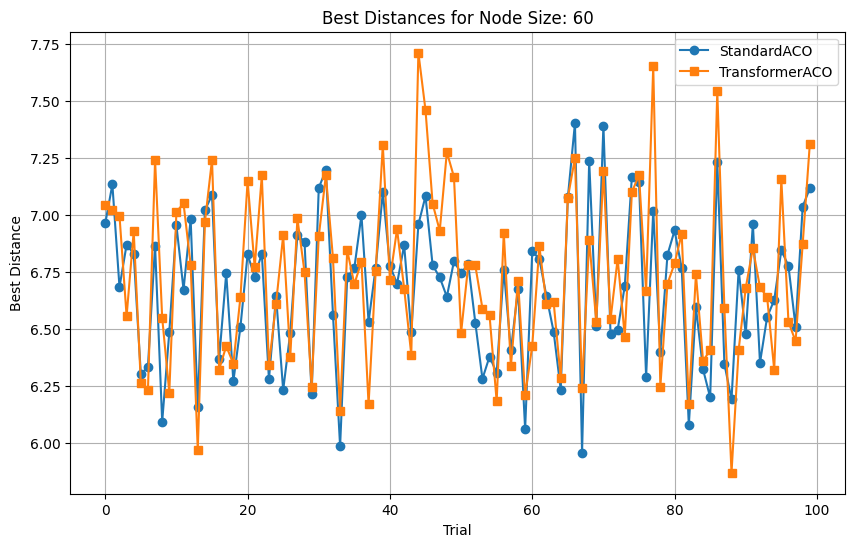

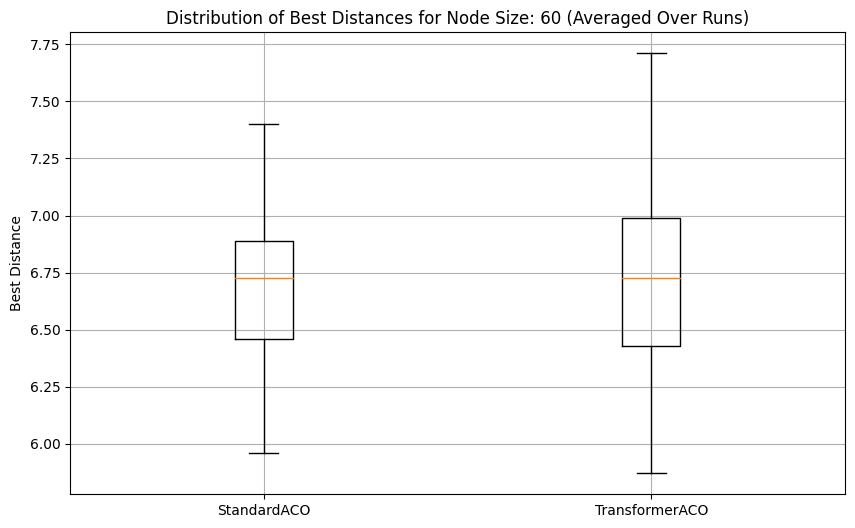


=== Node Size: 90 ===
Generating synthetic data for training...



Generating TSP Solutions: 100%|██████████| 500/500 [34:32<00:00,  4.15s/it]


Training Transformer Model...
Epoch 1/1000, Train Loss: 257.5416, Val Loss: 8.9405
Epoch 2/1000, Train Loss: 3.9991, Val Loss: 1.5852
Epoch 3/1000, Train Loss: 0.9091, Val Loss: 0.2394
Epoch 4/1000, Train Loss: 0.2782, Val Loss: 0.0560
Epoch 5/1000, Train Loss: 0.1711, Val Loss: 0.0190
Epoch 6/1000, Train Loss: 0.1370, Val Loss: 0.0107
Epoch 7/1000, Train Loss: 0.1213, Val Loss: 0.0081
Epoch 8/1000, Train Loss: 0.1133, Val Loss: 0.0072
Epoch 9/1000, Train Loss: 0.1076, Val Loss: 0.0068
Epoch 10/1000, Train Loss: 0.1028, Val Loss: 0.0067
Epoch 11/1000, Train Loss: 0.0977, Val Loss: 0.0066
Epoch 12/1000, Train Loss: 0.0931, Val Loss: 0.0066
Epoch 13/1000, Train Loss: 0.0894, Val Loss: 0.0066
Epoch 14/1000, Train Loss: 0.0853, Val Loss: 0.0066
Epoch 15/1000, Train Loss: 0.0811, Val Loss: 0.0066
Epoch 16/1000, Train Loss: 0.0786, Val Loss: 0.0066
Epoch 17/1000, Train Loss: 0.0753, Val Loss: 0.0066
Epoch 18/1000, Train Loss: 0.0723, Val Loss: 0.0066
Epoch 19/1000, Train Loss: 0.0693, Val Lo

<ipython-input-10-801569d92a95>:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_model_{num_nodes}.pth'))


Epoch 35/1000, Train Loss: 0.0580, Val Loss: 0.0066
Early stopping triggered.
Running 100 trials for node size 90...



Trials for node size 90:   1%|          | 1/100 [00:11<19:42, 11.95s/it]

Trial 1: StandardACO Best Distance = 9.0645, TransformerACO Best Distance = 8.6807



Trials for node size 90:   2%|▏         | 2/100 [00:22<18:35, 11.39s/it]

Trial 2: StandardACO Best Distance = 8.3845, TransformerACO Best Distance = 8.2688



Trials for node size 90:   3%|▎         | 3/100 [00:34<18:19, 11.34s/it]

Trial 3: StandardACO Best Distance = 8.0821, TransformerACO Best Distance = 8.6372



Trials for node size 90:   4%|▍         | 4/100 [00:45<18:11, 11.37s/it]

Trial 4: StandardACO Best Distance = 8.1440, TransformerACO Best Distance = 8.5178



Trials for node size 90:   5%|▌         | 5/100 [00:57<18:19, 11.57s/it]

Trial 5: StandardACO Best Distance = 8.7770, TransformerACO Best Distance = 9.0466



Trials for node size 90:   6%|▌         | 6/100 [01:08<17:50, 11.39s/it]

Trial 6: StandardACO Best Distance = 7.6200, TransformerACO Best Distance = 7.6994



Trials for node size 90:   7%|▋         | 7/100 [01:19<17:33, 11.33s/it]

Trial 7: StandardACO Best Distance = 8.2720, TransformerACO Best Distance = 8.0277



Trials for node size 90:   8%|▊         | 8/100 [01:31<17:33, 11.45s/it]

Trial 8: StandardACO Best Distance = 8.2534, TransformerACO Best Distance = 8.3903



Trials for node size 90:   9%|▉         | 9/100 [01:44<17:51, 11.78s/it]

Trial 9: StandardACO Best Distance = 8.9531, TransformerACO Best Distance = 8.2740



Trials for node size 90:  10%|█         | 10/100 [01:56<17:59, 11.99s/it]

Trial 10: StandardACO Best Distance = 8.2135, TransformerACO Best Distance = 7.6019



Trials for node size 90:  11%|█         | 11/100 [02:07<17:19, 11.67s/it]

Trial 11: StandardACO Best Distance = 8.5465, TransformerACO Best Distance = 8.7244



Trials for node size 90:  12%|█▏        | 12/100 [02:18<17:00, 11.59s/it]

Trial 12: StandardACO Best Distance = 8.5188, TransformerACO Best Distance = 8.1094



Trials for node size 90:  13%|█▎        | 13/100 [02:30<16:42, 11.52s/it]

Trial 13: StandardACO Best Distance = 8.9580, TransformerACO Best Distance = 8.7039



Trials for node size 90:  14%|█▍        | 14/100 [02:42<16:39, 11.62s/it]

Trial 14: StandardACO Best Distance = 8.5749, TransformerACO Best Distance = 8.1697



Trials for node size 90:  15%|█▌        | 15/100 [02:55<17:09, 12.11s/it]

Trial 15: StandardACO Best Distance = 8.3970, TransformerACO Best Distance = 8.5043



Trials for node size 90:  16%|█▌        | 16/100 [03:06<16:45, 11.96s/it]

Trial 16: StandardACO Best Distance = 7.7902, TransformerACO Best Distance = 7.6058



Trials for node size 90:  17%|█▋        | 17/100 [03:20<17:20, 12.54s/it]

Trial 17: StandardACO Best Distance = 8.1974, TransformerACO Best Distance = 8.7929



Trials for node size 90:  18%|█▊        | 18/100 [03:33<17:05, 12.51s/it]

Trial 18: StandardACO Best Distance = 8.1834, TransformerACO Best Distance = 8.2906



Trials for node size 90:  19%|█▉        | 19/100 [03:44<16:24, 12.16s/it]

Trial 19: StandardACO Best Distance = 8.2671, TransformerACO Best Distance = 7.8137



Trials for node size 90:  20%|██        | 20/100 [03:55<15:49, 11.87s/it]

Trial 20: StandardACO Best Distance = 8.6734, TransformerACO Best Distance = 9.0526



Trials for node size 90:  21%|██        | 21/100 [04:07<15:44, 11.95s/it]

Trial 21: StandardACO Best Distance = 7.5090, TransformerACO Best Distance = 7.6372



Trials for node size 90:  22%|██▏       | 22/100 [04:19<15:12, 11.69s/it]

Trial 22: StandardACO Best Distance = 8.3763, TransformerACO Best Distance = 8.6545



Trials for node size 90:  23%|██▎       | 23/100 [04:30<14:56, 11.64s/it]

Trial 23: StandardACO Best Distance = 8.9119, TransformerACO Best Distance = 8.7618



Trials for node size 90:  24%|██▍       | 24/100 [04:41<14:35, 11.52s/it]

Trial 24: StandardACO Best Distance = 8.7451, TransformerACO Best Distance = 9.0759



Trials for node size 90:  25%|██▌       | 25/100 [04:53<14:25, 11.54s/it]

Trial 25: StandardACO Best Distance = 8.4983, TransformerACO Best Distance = 8.2409



Trials for node size 90:  26%|██▌       | 26/100 [05:04<14:04, 11.41s/it]

Trial 26: StandardACO Best Distance = 8.9896, TransformerACO Best Distance = 8.5291



Trials for node size 90:  27%|██▋       | 27/100 [05:15<13:46, 11.32s/it]

Trial 27: StandardACO Best Distance = 7.9798, TransformerACO Best Distance = 8.2851



Trials for node size 90:  28%|██▊       | 28/100 [05:26<13:36, 11.34s/it]

Trial 28: StandardACO Best Distance = 8.9313, TransformerACO Best Distance = 8.6710



Trials for node size 90:  29%|██▉       | 29/100 [05:38<13:22, 11.30s/it]

Trial 29: StandardACO Best Distance = 8.6534, TransformerACO Best Distance = 8.8445



Trials for node size 90:  30%|███       | 30/100 [05:49<13:06, 11.24s/it]

Trial 30: StandardACO Best Distance = 8.6877, TransformerACO Best Distance = 9.1285



Trials for node size 90:  31%|███       | 31/100 [06:00<13:03, 11.35s/it]

Trial 31: StandardACO Best Distance = 7.6071, TransformerACO Best Distance = 8.3428



Trials for node size 90:  32%|███▏      | 32/100 [06:12<12:48, 11.31s/it]

Trial 32: StandardACO Best Distance = 8.0354, TransformerACO Best Distance = 7.9604



Trials for node size 90:  33%|███▎      | 33/100 [06:23<12:40, 11.35s/it]

Trial 33: StandardACO Best Distance = 8.1254, TransformerACO Best Distance = 8.3916



Trials for node size 90:  34%|███▍      | 34/100 [06:35<12:42, 11.55s/it]

Trial 34: StandardACO Best Distance = 8.1263, TransformerACO Best Distance = 8.3021



Trials for node size 90:  35%|███▌      | 35/100 [06:46<12:21, 11.40s/it]

Trial 35: StandardACO Best Distance = 8.2141, TransformerACO Best Distance = 8.0276



Trials for node size 90:  36%|███▌      | 36/100 [06:57<12:06, 11.36s/it]

Trial 36: StandardACO Best Distance = 8.5050, TransformerACO Best Distance = 8.6363



Trials for node size 90:  37%|███▋      | 37/100 [07:08<11:49, 11.26s/it]

Trial 37: StandardACO Best Distance = 8.5751, TransformerACO Best Distance = 9.2535



Trials for node size 90:  38%|███▊      | 38/100 [07:21<12:11, 11.79s/it]

Trial 38: StandardACO Best Distance = 8.2485, TransformerACO Best Distance = 8.6746



Trials for node size 90:  39%|███▉      | 39/100 [07:33<11:52, 11.68s/it]

Trial 39: StandardACO Best Distance = 8.0781, TransformerACO Best Distance = 8.1186



Trials for node size 90:  40%|████      | 40/100 [07:44<11:29, 11.49s/it]

Trial 40: StandardACO Best Distance = 8.4604, TransformerACO Best Distance = 8.4976



Trials for node size 90:  41%|████      | 41/100 [07:55<11:09, 11.35s/it]

Trial 41: StandardACO Best Distance = 7.6248, TransformerACO Best Distance = 7.1234



Trials for node size 90:  42%|████▏     | 42/100 [08:06<10:53, 11.27s/it]

Trial 42: StandardACO Best Distance = 8.2728, TransformerACO Best Distance = 8.3443



Trials for node size 90:  43%|████▎     | 43/100 [08:17<10:41, 11.26s/it]

Trial 43: StandardACO Best Distance = 8.0043, TransformerACO Best Distance = 8.6373



Trials for node size 90:  44%|████▍     | 44/100 [08:30<11:02, 11.84s/it]

Trial 44: StandardACO Best Distance = 7.8974, TransformerACO Best Distance = 8.4177



Trials for node size 90:  45%|████▌     | 45/100 [08:41<10:37, 11.59s/it]

Trial 45: StandardACO Best Distance = 8.4062, TransformerACO Best Distance = 8.9425



Trials for node size 90:  46%|████▌     | 46/100 [08:53<10:17, 11.43s/it]

Trial 46: StandardACO Best Distance = 8.5738, TransformerACO Best Distance = 8.7114



Trials for node size 90:  47%|████▋     | 47/100 [09:04<10:03, 11.39s/it]

Trial 47: StandardACO Best Distance = 8.6666, TransformerACO Best Distance = 8.2373



Trials for node size 90:  48%|████▊     | 48/100 [09:15<09:46, 11.28s/it]

Trial 48: StandardACO Best Distance = 8.2850, TransformerACO Best Distance = 8.3456



Trials for node size 90:  49%|████▉     | 49/100 [09:26<09:36, 11.31s/it]

Trial 49: StandardACO Best Distance = 8.3186, TransformerACO Best Distance = 8.3297



Trials for node size 90:  50%|█████     | 50/100 [09:38<09:35, 11.50s/it]

Trial 50: StandardACO Best Distance = 8.1983, TransformerACO Best Distance = 8.2853



Trials for node size 90:  51%|█████     | 51/100 [09:50<09:24, 11.52s/it]

Trial 51: StandardACO Best Distance = 8.3745, TransformerACO Best Distance = 8.6374



Trials for node size 90:  52%|█████▏    | 52/100 [10:02<09:25, 11.79s/it]

Trial 52: StandardACO Best Distance = 8.6664, TransformerACO Best Distance = 9.0475



Trials for node size 90:  53%|█████▎    | 53/100 [10:14<09:19, 11.90s/it]

Trial 53: StandardACO Best Distance = 8.1048, TransformerACO Best Distance = 8.0207



Trials for node size 90:  54%|█████▍    | 54/100 [10:25<08:56, 11.66s/it]

Trial 54: StandardACO Best Distance = 7.9484, TransformerACO Best Distance = 8.8219



Trials for node size 90:  55%|█████▌    | 55/100 [10:37<08:41, 11.59s/it]

Trial 55: StandardACO Best Distance = 9.0583, TransformerACO Best Distance = 8.8725



Trials for node size 90:  56%|█████▌    | 56/100 [10:48<08:21, 11.40s/it]

Trial 56: StandardACO Best Distance = 7.9681, TransformerACO Best Distance = 9.1572



Trials for node size 90:  57%|█████▋    | 57/100 [10:59<08:05, 11.29s/it]

Trial 57: StandardACO Best Distance = 8.5638, TransformerACO Best Distance = 8.7141



Trials for node size 90:  58%|█████▊    | 58/100 [11:10<07:50, 11.21s/it]

Trial 58: StandardACO Best Distance = 8.4398, TransformerACO Best Distance = 8.4345



Trials for node size 90:  59%|█████▉    | 59/100 [11:21<07:38, 11.18s/it]

Trial 59: StandardACO Best Distance = 8.5441, TransformerACO Best Distance = 7.8960



Trials for node size 90:  60%|██████    | 60/100 [11:32<07:26, 11.16s/it]

Trial 60: StandardACO Best Distance = 8.6063, TransformerACO Best Distance = 8.4327



Trials for node size 90:  61%|██████    | 61/100 [11:43<07:15, 11.18s/it]

Trial 61: StandardACO Best Distance = 8.9136, TransformerACO Best Distance = 8.8535



Trials for node size 90:  62%|██████▏   | 62/100 [11:55<07:08, 11.27s/it]

Trial 62: StandardACO Best Distance = 7.9586, TransformerACO Best Distance = 7.8162



Trials for node size 90:  63%|██████▎   | 63/100 [12:06<06:56, 11.27s/it]

Trial 63: StandardACO Best Distance = 8.5337, TransformerACO Best Distance = 8.0558



Trials for node size 90:  64%|██████▍   | 64/100 [12:17<06:44, 11.23s/it]

Trial 64: StandardACO Best Distance = 8.3636, TransformerACO Best Distance = 9.0529



Trials for node size 90:  65%|██████▌   | 65/100 [12:28<06:29, 11.13s/it]

Trial 65: StandardACO Best Distance = 8.2574, TransformerACO Best Distance = 8.4936



Trials for node size 90:  66%|██████▌   | 66/100 [12:40<06:31, 11.52s/it]

Trial 66: StandardACO Best Distance = 8.4685, TransformerACO Best Distance = 8.4402



Trials for node size 90:  67%|██████▋   | 67/100 [12:52<06:15, 11.38s/it]

Trial 67: StandardACO Best Distance = 8.3653, TransformerACO Best Distance = 8.5545



Trials for node size 90:  68%|██████▊   | 68/100 [13:03<06:01, 11.31s/it]

Trial 68: StandardACO Best Distance = 7.4176, TransformerACO Best Distance = 8.5686



Trials for node size 90:  69%|██████▉   | 69/100 [13:14<05:52, 11.37s/it]

Trial 69: StandardACO Best Distance = 8.3308, TransformerACO Best Distance = 8.0805



Trials for node size 90:  70%|███████   | 70/100 [13:25<05:40, 11.35s/it]

Trial 70: StandardACO Best Distance = 7.9747, TransformerACO Best Distance = 8.8679



Trials for node size 90:  71%|███████   | 71/100 [13:37<05:30, 11.41s/it]

Trial 71: StandardACO Best Distance = 7.7484, TransformerACO Best Distance = 7.8635



Trials for node size 90:  72%|███████▏  | 72/100 [13:49<05:20, 11.43s/it]

Trial 72: StandardACO Best Distance = 8.6593, TransformerACO Best Distance = 7.7857



Trials for node size 90:  73%|███████▎  | 73/100 [14:00<05:11, 11.52s/it]

Trial 73: StandardACO Best Distance = 8.7535, TransformerACO Best Distance = 8.8432



Trials for node size 90:  74%|███████▍  | 74/100 [14:11<04:55, 11.36s/it]

Trial 74: StandardACO Best Distance = 8.2307, TransformerACO Best Distance = 8.0447



Trials for node size 90:  75%|███████▌  | 75/100 [14:22<04:42, 11.29s/it]

Trial 75: StandardACO Best Distance = 9.2567, TransformerACO Best Distance = 9.0322



Trials for node size 90:  76%|███████▌  | 76/100 [14:33<04:29, 11.24s/it]

Trial 76: StandardACO Best Distance = 8.6860, TransformerACO Best Distance = 8.8407



Trials for node size 90:  77%|███████▋  | 77/100 [14:45<04:20, 11.35s/it]

Trial 77: StandardACO Best Distance = 8.2770, TransformerACO Best Distance = 8.1577



Trials for node size 90:  78%|███████▊  | 78/100 [14:57<04:10, 11.38s/it]

Trial 78: StandardACO Best Distance = 8.7320, TransformerACO Best Distance = 9.1970



Trials for node size 90:  79%|███████▉  | 79/100 [15:08<03:58, 11.34s/it]

Trial 79: StandardACO Best Distance = 8.3870, TransformerACO Best Distance = 8.3275



Trials for node size 90:  80%|████████  | 80/100 [15:19<03:48, 11.40s/it]

Trial 80: StandardACO Best Distance = 8.5014, TransformerACO Best Distance = 8.5356



Trials for node size 90:  81%|████████  | 81/100 [15:32<03:41, 11.68s/it]

Trial 81: StandardACO Best Distance = 8.8377, TransformerACO Best Distance = 9.0096



Trials for node size 90:  82%|████████▏ | 82/100 [15:45<03:38, 12.12s/it]

Trial 82: StandardACO Best Distance = 8.6883, TransformerACO Best Distance = 8.9441



Trials for node size 90:  83%|████████▎ | 83/100 [15:56<03:21, 11.84s/it]

Trial 83: StandardACO Best Distance = 8.5255, TransformerACO Best Distance = 8.2963



Trials for node size 90:  84%|████████▍ | 84/100 [16:07<03:07, 11.71s/it]

Trial 84: StandardACO Best Distance = 8.3180, TransformerACO Best Distance = 8.4897



Trials for node size 90:  85%|████████▌ | 85/100 [16:19<02:55, 11.67s/it]

Trial 85: StandardACO Best Distance = 8.3464, TransformerACO Best Distance = 8.1003



Trials for node size 90:  86%|████████▌ | 86/100 [16:31<02:43, 11.71s/it]

Trial 86: StandardACO Best Distance = 9.2017, TransformerACO Best Distance = 8.7439



Trials for node size 90:  87%|████████▋ | 87/100 [16:42<02:30, 11.57s/it]

Trial 87: StandardACO Best Distance = 8.6365, TransformerACO Best Distance = 8.3728



Trials for node size 90:  88%|████████▊ | 88/100 [16:53<02:17, 11.45s/it]

Trial 88: StandardACO Best Distance = 8.8426, TransformerACO Best Distance = 8.5267



Trials for node size 90:  89%|████████▉ | 89/100 [17:05<02:07, 11.60s/it]

Trial 89: StandardACO Best Distance = 8.7510, TransformerACO Best Distance = 8.9214



Trials for node size 90:  90%|█████████ | 90/100 [17:17<01:56, 11.66s/it]

Trial 90: StandardACO Best Distance = 7.9904, TransformerACO Best Distance = 8.1889



Trials for node size 90:  91%|█████████ | 91/100 [17:29<01:45, 11.69s/it]

Trial 91: StandardACO Best Distance = 8.3561, TransformerACO Best Distance = 8.1271



Trials for node size 90:  92%|█████████▏| 92/100 [17:40<01:32, 11.57s/it]

Trial 92: StandardACO Best Distance = 8.4415, TransformerACO Best Distance = 8.6134



Trials for node size 90:  93%|█████████▎| 93/100 [17:51<01:20, 11.51s/it]

Trial 93: StandardACO Best Distance = 8.4180, TransformerACO Best Distance = 8.4045



Trials for node size 90:  94%|█████████▍| 94/100 [18:02<01:08, 11.39s/it]

Trial 94: StandardACO Best Distance = 7.8161, TransformerACO Best Distance = 8.0049



Trials for node size 90:  95%|█████████▌| 95/100 [18:13<00:56, 11.29s/it]

Trial 95: StandardACO Best Distance = 8.6855, TransformerACO Best Distance = 8.5326



Trials for node size 90:  96%|█████████▌| 96/100 [18:26<00:46, 11.55s/it]

Trial 96: StandardACO Best Distance = 8.3512, TransformerACO Best Distance = 8.2905



Trials for node size 90:  97%|█████████▋| 97/100 [18:37<00:34, 11.47s/it]

Trial 97: StandardACO Best Distance = 7.7551, TransformerACO Best Distance = 8.2102



Trials for node size 90:  98%|█████████▊| 98/100 [18:49<00:23, 11.56s/it]

Trial 98: StandardACO Best Distance = 8.1007, TransformerACO Best Distance = 8.2446



Trials for node size 90:  99%|█████████▉| 99/100 [19:00<00:11, 11.47s/it]

Trial 99: StandardACO Best Distance = 7.8265, TransformerACO Best Distance = 7.6193



Trials for node size 90: 100%|██████████| 100/100 [19:11<00:00, 11.52s/it]

Trial 100: StandardACO Best Distance = 8.4487, TransformerACO Best Distance = 7.8975


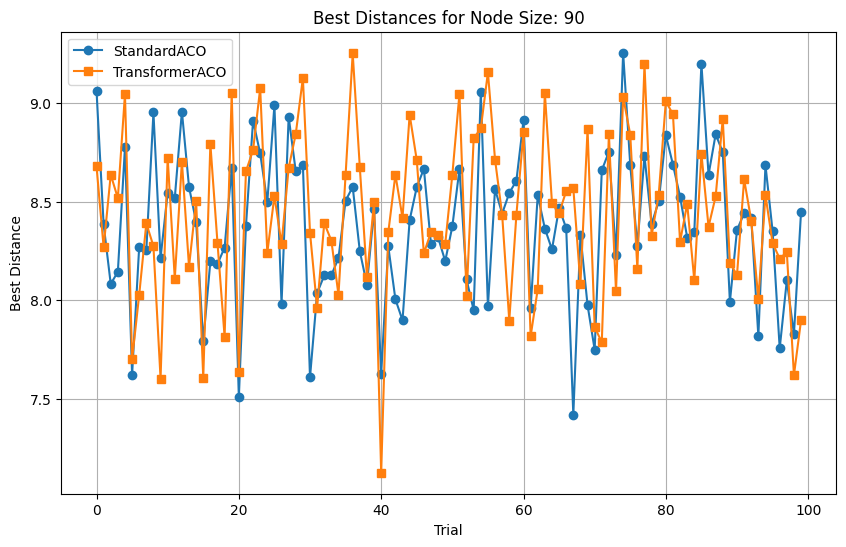

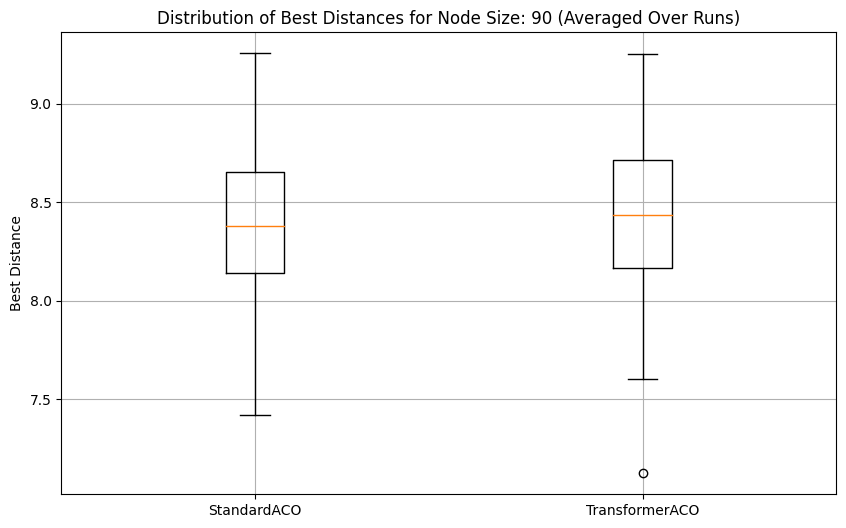


=== Statistical Significance Testing ===
Node Size 30: p-value = 8.8345e-01
Node Size 60: p-value = 5.4603e-02
Node Size 90: p-value = 2.7122e-01


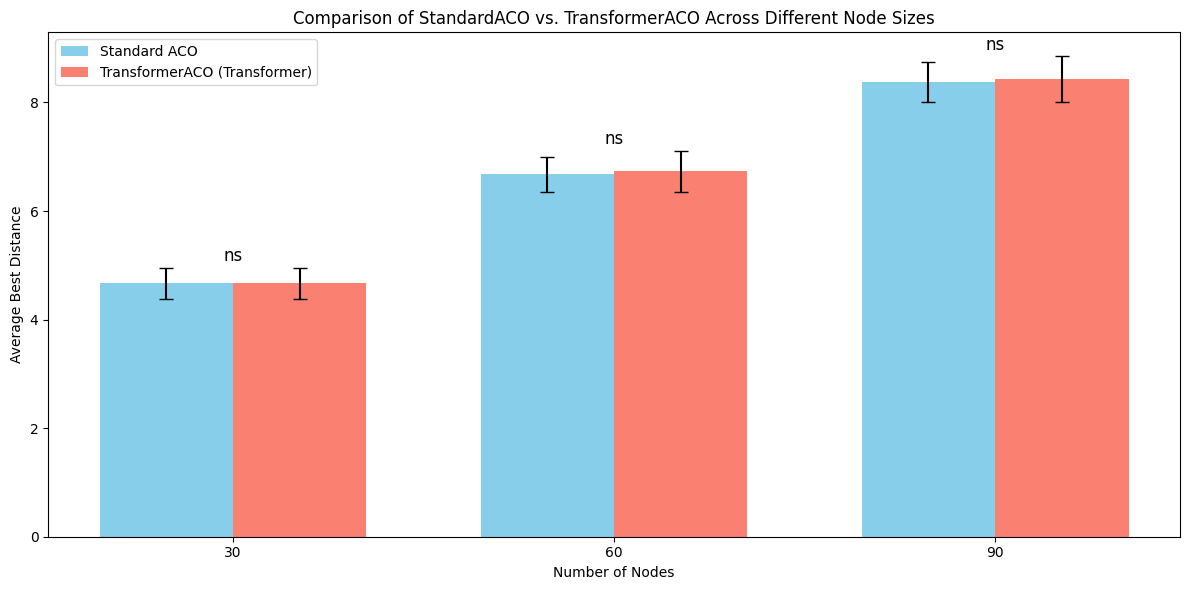

In [13]:
node_sizes = [30,60,90]

num_trials = 100
iterations = 50
num_ants = 20
alpha = 1.0
beta = 2.0
evaporation_rate = 0.5
Q = 100

results = run_experiment(
    node_sizes=node_sizes,
    num_trials=num_trials,
    iterations=iterations,
    num_ants=num_ants,
    alpha=alpha,
    beta=beta,
    evaporation_rate=evaporation_rate,
    Q=Q
)

print("\n=== Statistical Significance Testing ===")
p_values = perform_statistical_tests(results)

plot_results(results, p_values)
